**Problema** : Riconoscere se il soggetto indossa una mascherina oppure non indossa nessuna protezione.

**Soluzone proposta**: Creo dizionario di visual word dalle immagini di training. Dalle immagini creo l'istogramma di visual word per ogni immagine e classifico tramite un classificatoe SVM.

La risoluzione con BoW passa per tre step principali:
* **Feature Extraction:** Determinare le mie feature che caratterizzano l'immagine.
* **Codebook Construction:**  Creazione del dizionario attraverso un algorito di clustering(k-means).
* **Classification:** Dato che BoW è agnostico al tipo di classificatore, per questo problema ho scelto di usare SVM essendo un classificatore molto performante. Per classificare le mie immagini uso un istogramma formato dalle visual word trovate nel dizionario.


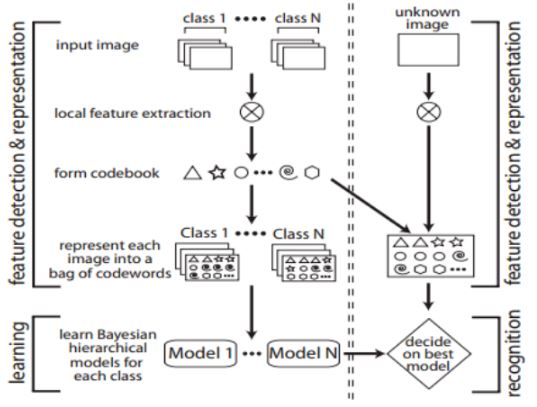

Importo le librerie che mi servono:

In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix
import cv2 as cv
import os
import matplotlib.pyplot as plt
import random
import pylab as pl

**Creo le strutture per i dati:**

In [2]:
train_path="archive/Face Mask Dataset/Train"
class_names=os.listdir(train_path)

In [3]:
print(class_names)

['WithMask', 'WithoutMask']


Creo due contenitori per il percoso delle immagini e la loro classe

In [4]:
image_paths=[]
image_classes=[]

Creare lista per tutti i filename nella directory

In [5]:
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

In [6]:
# ciclo for su ogni classe del training set
for training_name in class_names:
    #estraggo la directory delle classi
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)#class 'generator', itero sulla classe 
    image_paths+=class_path #vado a creare una lista della posizione di ogni immagine
#in totale ho 10000 immagini di test, 5000 per ogni classe

In [7]:
image_classes_0=[0]*(len(image_paths)//2)# creo label per ogni classe

In [8]:
image_classes_1=[1]*(len(image_paths)//2)# creo label per ogni classe

In [9]:
image_classes=image_classes_0+image_classes_1
len(image_classes)

10000

ora ad ogni immagine assegno l'etichetta:
* zero = withmask
* uno = withoutmask

In [10]:
D=[]
#la struttura D contiene il path dell'immagine con la sua corrispettiva etichetta
for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))
    
print('esempio struttura: ',D[1])

esempio struttura:  ('archive/Face Mask Dataset/Train\\WithMask\\100.png', 0)


Visualizzo due esempio del mio dataset di training:

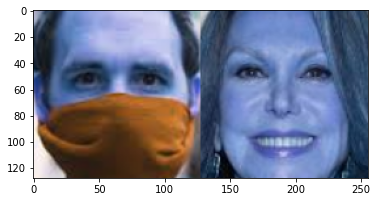

In [11]:
#visualizzo due esempi delle mie due classi 
import numpy as np
import matplotlib.pyplot as plt

img_A =  cv.imread(D[50][0])
img_B =  cv.imread(D[5000][0])

#per visualizzare le due immagini le ho inserite in un numpy array e poi ho plottato l'array
dim=(128,128)
img_A_2= cv.resize(img_A,dim)
img_B_2= cv.resize(img_B,dim)
plot_image = np.concatenate((img_A_2, img_B_2), axis=1)

plt.imshow(plot_image)

Ora che ho messo in ordine le mie immagini di training con le loro rispettive etichette posso inziare la fase di feature extraction usando la metodologia Bag of Word

**Estrazione delle feature con BOW:**
* Quando carico le immagini ho deciso di estrarre le feature solo dalla metà inferiore perchè così mi concentro molto di più sulle visual word della mascherina vs le visual word della bocca e del naso. Infatti le visual word che descrivono gli occhi si trovano in entrambe le classi. Questa decisione è discutibile perchè se leggo in input un'immagine ruotata di 90° il reagionamento non è più valido. Ho usato questo sistema solo perchè nelle immagini di traning e nelle immagini di testing ho tutte immagini orientate correttamente.
* Una volta caricate le immagini vado a calcolarmi i keypoint e da essi mi calcolo i descrittori. Questi descrittori sono le mie feature di tipo SIFT(Scale_invariant_feature_trasform). Cioè un vettore 128 dimensionale che racchiude le informazioni che caratterizzano il keypoint trovato. Formao da 128 dimensioni perchè inizialmente divide la mia patch in 4x4, quindi 16 quadratini formati da pixel e poi per ogni quandratino viene registrato l'orientamento dell'edge, questi orientamenti vengono raggruppati in 8 direzioni e qundi 8x16=128.

Vediamo un piccolo esempio di quello che andremo a fare su tutto il dataset:

<class 'cv2.xfeatures2d_SIFT'>


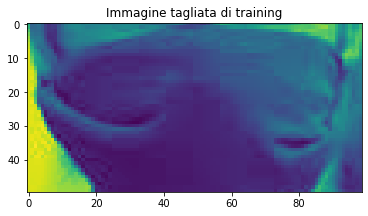

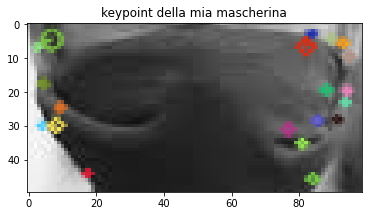

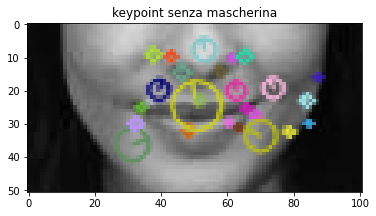

In [51]:
#calcolo che devo fare per ogni immagine e mi creo la mia lista di descrittori che sono le mie SIFT
#carico imamgine
img = cv.imread(D[50][0])
cut_image = img[img.shape[0]//2: img.shape[0], 0:img.shape[1]]#prendo solo metà inferiore
gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
plt.figure(1)
plt.title('Immagine tagliata di training')
plt.imshow(gray)

sift = cv.xfeatures2d.SIFT_create() #creo oggetto sift
print(type(sift))

kp = sift.detect(gray,None) #trova i keypoint nell'immagine 
img_1=cv.drawKeypoints(gray,kp,cut_image,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #disegno cerchi intorni ai miei keypoint
plt.figure(2)
plt.title('keypoint della mia mascherina')
plt.imshow(img_1)
kp,des = sift.compute(gray,kp)#calcolo descitori, è un array di N(#keypoint)x128

#visualizzio keypoint immagini senza mascherina
img_nomask=cv.imread(D[6031][0])
cut_image_nomask=img_nomask[img_nomask.shape[0]//2: img_nomask.shape[0], 0:img_nomask.shape[1]]
gray_nomask= cv.cvtColor(cut_image_nomask,cv.COLOR_BGR2GRAY)#la porto in scala di grigi

kp = sift.detect(gray_nomask,None) #trova i keypoint nell'immagine 
img_1_nomask=cv.drawKeypoints(gray_nomask,kp,cut_image_nomask,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #disegno cerchi intorni ai miei keypoint
plt.figure(3)
plt.title('keypoint senza mascherina')
plt.imshow(img_1_nomask)

Ora vado ad estrarmi i descrittori per ogni immagine del dataset:
* quando calcolo i descrittori certe volte l'algoritmo non trova nessun punto chiave, allora a questo punto non tengo conto dell'immagine per allenare il mio vocabolario

In [13]:
#oggetto sift già istanziato
tot_list=[]#lista descrittori con immagini associata
des_list=[] #lista per descrittori, la uso dopo
new_D=[]#nuovo dataset con classi e immagini non Null
p=0

from tqdm import tqdm #algoritmo intelligente che calcola tempo di esecuzione rimanente
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

for i in tqdm(range(len(image_paths)), desc='Calcolo Keypoint e descrittori'):
    
    im=cv.imread(D[i][0])
    cut_image = im[im.shape[0]//2: im.shape[0], 0:im.shape[1]]
    cut_image_gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
    
    kp1, descriptor = sift.detectAndCompute(cut_image_gray,None)#trovo keypoit e calcolo descrittori in un colpo solo
        
    if descriptor is not None:#se non è nullo lo aggiungo alla mia lista di descrittori e aggiorno una nuova struttura per memorizzare immagini valide
        p+=1
        new_D.append((D[i][0],D[i][1]))
        tot_list.append((D[i][0],descriptor))
        des_list.extend(descriptor) #extend a differenza di append aggiunge un singolo elemento alla volta alla lista
        # es: 'ciao' => 'c' 'i' 'a' 'o'
print('dal mio train set ho tenuto',p,' immagini')

Calcolo Keypoint e descrittori: 100%|██████████| 10000/10000 [01:13<00:00, 136.61it/s]

dal mio train set ho tenuto 9968  immagini


Dato che ho cambiato il mio dataset devo sistemare anche la lista delle label:

In [14]:

image_classes_0=[]
image_classes_1=[]

for i in range(len(new_D)):
    
    #D.append((image_paths[i],image_classes[i])
    if(new_D[i][1]==0):
        
        image_classes_0.append(0)# creo label per ogni classe
    else:
        image_classes_1.append(1)

        
image_classes=image_classes_0+image_classes_1;



Implemento algorimto K-means sui descrittori, creo dizionario BOW.

Con l'algoritmo K-means vado a stimarmi i parametri della mia distribuzione. In questo caso l'algorimto Kmenas mi restiturisce:
* il vocabolario= Una matrice k per N(dimensioni delle mie feature) di k centroidi.
* la varianza= La distanza euclidea media (non quadrata) tra le osservazioni passate e i centroidi generati. Notare la differenza con la definizione standard di distorsione nel contesto dell'algoritmo k-means, che è la somma delle distanze al quadrato. Questo parametro non mi serve.

A noi interessa soltanto il Dizionario formato dalle K centroidi che rappresentano meglio il nostro dataset di training.

In [16]:
from scipy.cluster.vq import kmeans,vq

k=20
voc,variance=kmeans(np.array(des_list),k,1)

In [53]:
print(voc.shape)

(20, 128)


**creo istogramma delle immagini:**
* 1): mi creo una matrice #samples x #_cluster
* 2): per ogni immagine del mio train set vado a prendermi i descrittori di quella immagine.
* 3): Grazie alla funzione vq che prende in input i descrittori dell'immagine e del vocabolario riesco a calcolarmi le visual word presenti nella mia immagine 
* 4): vado ad iterare sulle visual word trovate e assegno +1 per ogni visual che ha la mia immagine

In [54]:
print("la lunghezza del nuovo dizionario è ",len(new_D),'la quale deve essere uguale a ',len(tot_list))


la lunghezza del nuovo dizionario è  9968 la quale deve essere uguale a  9968


**Creo il mio istogramma delle feature**

In [22]:
im_features=np.zeros((len(new_D),k),"float32")#matrice 10000 x #_cluster, numero immagini di test per bins

for i in range(len(new_D)):#per ogni immagine creo struttura con quante visual word contiene 
    
    #print(tot_list[i][1])
    words,distance=vq(tot_list[i][1],voc)
    #ritorna words = Un array di lunghezza M(patch trovate nell'immagine) che contiene l'indice della parola nel dizionario dei codici per ogni osservazione. 
    #riotna distance tra l'osservazione e la piu vicina visual
    for w in words:
        im_features[i][w]+=1#inizialmnete il mio istogramma è tutto a zero[0 0 ... 0 0 0]
        #poi man mano aggiungo le visual word trovate per quell'immagine


**Applico standardizzazione dei dati:** faccio scalatura dei dati per questioni di ottimizzazione, infatti è meglio tenre numeri bassi e intorno allo zero. Ci sono tanti tipi di normalizzazione, in questo caso uso la Z-norm.

In [23]:
from sklearn.preprocessing import StandardScaler

stdslr=StandardScaler().fit(im_features)# Compute the mean and std to be used for later scaling.
im_features=stdslr.transform(im_features)# Perform standardization by centering and scaling, z = (x - u) / std


**Classificazione degli istogrammi con SVM**

Proviamo due tipi di Kernel:
* 1)kernel lineare
* 2)Kernel RBF

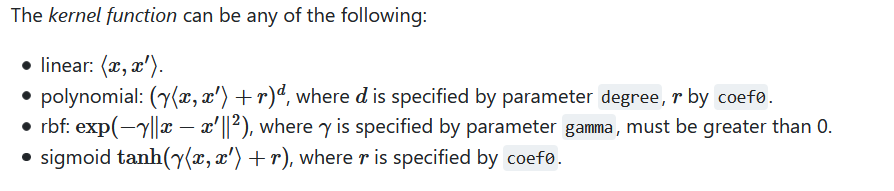

**Kernel Lineare:**

In [25]:
from sklearn.svm import LinearSVC

SVM_Linear=LinearSVC(max_iter=80000, verbose=1)# C=1
SVM_Linear.fit(im_features,np.array(image_classes))

[LibLinear]

LinearSVC(max_iter=80000, verbose=1)

**Test del Classificatore**
* 1) Prendo immagini di test e ne calcolo i descrittori SIFT
* 2) Creo l'istogramma con il vocabolario allenato in precedenza
* 3) Classifico con SVM appena allenata

In [30]:
des_list_test=[] #creo lista di descrittori per le miei immagini di test 

In [31]:
#creo set di test
test_path="archive/Face Mask Dataset/Test"
class_names_test=os.listdir(test_path)

print(class_names_test)
image_paths_test=[]
image_classes_test=[]

def img_list_test(path):#itero sulla classe
    return (os.path.join(path,f) for f in os.listdir(path))

for test_name in class_names_test: #itero sulle mie due classi in gioco
    dir_=os.path.join(test_path,test_name)#directori dove di trova le immagini
    class_path_test=img_list_test(dir_)
    image_paths_test+=class_path_test#vado a creare una lista della posizione di ogni immagine
    
#NB 483 immagini withMask e 509 without mask 

['WithMask', 'WithoutMask']


In [32]:
#creo label test set
len(image_paths_test)
Test_D=[]
for i in range(len(image_paths_test)):
    if (i<483):
        Test_D.append((image_paths_test[i],0))
    else:
        Test_D.append((image_paths_test[i],1)) 

        
#Nb: 0=withMask, 1=withoutMask

In [33]:
#test del test_D, usato per vedere se avevo classificato correttamente       
''' img_A_test =  cv.imread(Test_D[800][0])
print(Test_D[481])
plt.imshow(img_A_test)'''

' img_A_test =  cv.imread(Test_D[800][0])\nprint(Test_D[481])\nplt.imshow(img_A_test)'

Estrapolo i descrittori dalle immagini di test:

In [34]:

for image_pat_test in image_paths_test:
    image=cv.imread(image_pat_test)
    cut_image = image[image.shape[0]//2: image.shape[0], 0:image.shape[1]]
    cut_image_gray= cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    kp=sift.detect(cut_image_gray,None)#trovo keypoint
    keypoints_test,descriptor_test= sift.compute(cut_image_gray, kp)#calcolo descrittori keypoint
    if descriptor_test is None: #nella maggior parte delle prove non ho riscontarato descrittori nulli
        print('trovato des null')
    des_list_test.append((image_pat_test,descriptor_test))

Creo il mio istogramma di testing:

In [35]:
test_features=np.zeros((len(image_paths_test),k),"float32")#matrice dove raccolgo le feture
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)#controllo le parole trovate in base a quanto distanti sono dai miei cluster
    for w in words:
        test_features[i][w]+=1

In [36]:
#stampo istogrammi, vedo già che ci sono delle differenze tra istogrammi di diverse classi  
''' print(test_features[400])
print(test_features[401])
print(test_features[800])
print(test_features[801])'''

' print(test_features[400])\nprint(test_features[401])\nprint(test_features[800])\nprint(test_features[801])'

In [37]:
#normalizzo le feature
stdslr=StandardScaler().fit(test_features)
test_features_norm=stdslr.transform(test_features)

In [38]:
#mi faccio un'idea delle mie feature normalizzate
'''print(test_features_norm[400])
print(test_features_norm[401])
print(test_features_norm[800])
print(test_features_norm[801])'''

'print(test_features_norm[400])\nprint(test_features_norm[401])\nprint(test_features_norm[800])\nprint(test_features_norm[801])'

In [39]:
#calcolo le classi vere
true_classes=[]
for i in Test_D:
    if i[1]==0:
        true_classes.append("WithMask")
    else:
        true_classes.append("WithoutMask")

In [40]:
#print(true_classes)

In [41]:
#predico le classi dal mio svm lineare 
predict_classes=[]
for i in SVM_Linear.predict(test_features_norm):
    if i==1:
        predict_classes.append("WithoutMask")
    else:
        predict_classes.append("WithMask")

In [44]:
#calcolo accuratezza del mio classificatore
accuracy=accuracy_score(true_classes,predict_classes)
print('accuratezza classificatore lineare= ',"{:.2f}".format(accuracy*100),'%')

accuratezza classificatore lineare=  87.30 %


**Testo anche il classificatori RBF e polinomiali passandoli diversi parametri e trovando i migliori**

In [45]:
# Train a SVM classification model, tempo di esecuzione del codice circa 12 minuti
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
Costo=[1e3, 5e3, 1e4, 5e4, 1e5]
GAMMA=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
max=0.0
gamma_top=0.0
c_top=0.0
for c in tqdm(Costo):
    
    for gamma in GAMMA:
        
        SVM_RBF=SVC(kernel='rbf',gamma=gamma,C=c)
        SVM_RBF = SVM_RBF.fit(im_features,np.array(image_classes))
        
        #predico le classi dal mio svm gaussiano
        predict_classes_RBF=[]
        for i in SVM_RBF.predict(test_features_norm):
            if i==1:
                predict_classes_RBF.append("WithoutMask")
            else:
                predict_classes_RBF.append("WithMask")
        #calcolo accuratezza del mio classificatore
        accuracy=accuracy_score(true_classes,predict_classes_RBF)
        
        #calcolo massima accuratezza
        if(accuracy > max):
            max=accuracy
            gamma_top=gamma
            c_top=c
print('massima accuratezza classificatore RBF= ',"{:.2f}".format(max*100),'%', ' gamma=',gamma_top, ' C=', c_top)            


100%|██████████| 5/5 [16:17<00:00, 195.50s/it]

massima accuratezza classificatore RBF=  89.21 %  gamma= 0.0001  C= 5000.0


In [46]:
# Train a SVM classification model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
Degree=[2,3,4.5]
coeff0=[0.0, 1.0]
max=0.0
coeff_top=0.0
degree_top=0.0
for d in tqdm(Degree):
    
    for coeff in coeff0:
        
        SVM_poly=SVC(kernel='poly',degree=d,coef0=coeff)
        SVM_poly = SVM_poly.fit(im_features,np.array(image_classes))
        
        #predico le classi dal mio svm gaussiano
        predict_classes_poly=[]
        for i in SVM_poly.predict(test_features_norm):
            if i==1:
                predict_classes_poly.append("WithoutMask")
            else:
                predict_classes_poly.append("WithMask")
        #calcolo accuratezza del mio classificatore
        accuracy=accuracy_score(true_classes,predict_classes_poly)
        
        
        if(accuracy > max):
            max=accuracy
            degreee_top=d
            coeff_top=coeff
            
print('massima accuratezza classificatore poly= ',"{:.2f}".format(max*100),'%', ' degreee=',degreee_top, ' coeff=', coeff_top) 

100%|██████████| 3/3 [00:09<00:00,  3.33s/it]

massima accuratezza classificatore poly=  86.09 %  degreee= 4.5  coeff= 1.0


**Conclusioni:**

Con il Kernel lineare abbiamo ottenuto un'accuratezza del 86% circa e anche con il Kernle polinomiale abbiamo ottenuto lo stesso risultato (ogni volta che eseguiamo il codice i risultati potebbero variare leggermente). Invece abbiamo sempre ottenuto una classificazione migliore del 2% con il Kernel RBF, arrivando ad una accuratezza dell'89%.
